# Building a movie recommender with Naïve Bayes

We herein use a movie rating dataset (https://grouplens.org/datasets/movielens/). The movie rating “data was collected by the GroupLens Research group from the MovieLens website (http://movielens.org).
For demonstration purposes, we will use the stable small dataset, MovieLens 1M Dataset (which can be downloaded from https://files.grouplens.org/datasets/movielens/ml-1m.zip or https://grouplens.org/datasets/movielens/1m/) for ml-1m.zip (size: 1 MB) file). It has around 1 million ratings, ranging from 1 to 5 with half-star increments, given by 6,040 users on 3,706 movies (last updated September 2018).
Unzip the ml-1m.zip file and you will see the following four files:

movies.dat: It contains the movie information in the format of MovieID::Title::Genres.
ratings.dat: It contains user movie ratings in the format of UserID::MovieID::Rating::Timestamp. We will only be using data from this file in this chapter.
users.dat: It contains user information in the format of UserID::Gender::Age::Occupation::Zip-code.
README

Let’s attempt to predict whether a user likes a particular movie based on how they rate other movies (again, ratings are from 1 to 5).

     


# Preparing the Data

First, we import all the necessary modules and read the ratings.dat 
into a pandas DataFrame object



In [71]:
import numpy as np
import pandas as pd


In [72]:
data_path = '~/Desktop/ml-1m /ratings.dat'

In [73]:
df = pd.read_csv(data_path,header=None,sep='::',engine='python')
df.columns= ['user_id','movie_id','rating','timestamp']
df

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


Now, let’s see how many unique users and movies are in this million-row dataset:


In [74]:
n_users = df['user_id'].nunique()
n_movies =df['movie_id'].nunique()


In [75]:
print(f"Number of users: {n_users}")
print(f"Number of movies:{n_movies}")

Number of users: 6040
Number of movies:3706


Next, we will construct a 6,040 (the number of users) by 3,706 (the number of movies) matrix where each row contains movie ratings from a user, and each column represents a movie, using the following function:



In [76]:
def load_user_rating_data(df, n_user,n_movies):
    data = np.zeros([n_users, n_movies],dtype=np.intc)
    
    movie_id_mapping = {}
    for user_id,movie_id,rating in zip(df['user_id'],df['movie_id'],df['rating']):
        user_id = int(user_id)-1
        if movie_id not in movie_id_mapping:
            movie_id_mapping[movie_id]=len(movie_id_mapping)
        data[user_id,movie_id_mapping[movie_id]]=rating 
    return data,movie_id_mapping
data,movie_id_mapping = load_user_rating_data(df,n_users,n_movies)


Besides the rating matrix data, we also record the movie ID to column index mapping. The column index is from 0 to 3,705 as we have 3,706 movies.
It is always recommended to analyze the data distribution in order to identify if there is a class imbalance issue in the dataset. We do the following:

In [77]:
values,counts = np.unique(data,return_counts=True)

for value, count in zip(values,counts):
    print(f'Number of rating{value}:{count}')

Number of rating0:21384031
Number of rating1:56174
Number of rating2:107557
Number of rating3:261197
Number of rating4:348971
Number of rating5:226310


As you can see, most ratings are unknown; for the known ones, 35% are of rating 4, followed by 26% of rating 3, 23% of rating 5, and then 11% and 6% of ratings 2 and 1, respectively.
Since most ratings are unknown, we take the movie with the most known ratings as our target movie for easier prediction validation. We look for rating counts for each movie as follows:



In [78]:
print(df['movie_id'].value_counts())

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: count, Length: 3706, dtype: int64


So, the target movie is ID, and we will treat ratings of other movies as features. We only use rows with ratings available for the target movie so we can validate how good the prediction is. We construct the dataset accordingly as follows:


In [79]:
target_movie_id =2858
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1)
Y_raw = data[:,movie_id_mapping[target_movie_id]]
X = X_raw[Y_raw >0]
Y = Y_raw[Y_raw >0]
print ('Shape of X:', X.shape)
print ('Shape of Y:', Y.shape)

Shape of X: (3428, 3705)
Shape of Y: (3428,)


We can consider movies with ratings greater than 3 as being liked (being recommended):



In [80]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')



2853 positive samples and 575 negative samples.


We use the train_test_split function from scikit-learn to do the random splitting and to preserve the percentage of samples for each class:


In [81]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,
                                test_size=0.2,random_state=42)

We check the training and testing sizes as follows:


In [82]:
print(len(Y_train), len(Y_test))

2742 686


Another good thing about the train_test_split function is that the resulting training and testing sets will have the same class ratio.



# Training a Naïve Bayes model

Next, we train a Naïve Bayes model on the training set. You may notice that the values of the input features are from 0 to 5, as opposed to 0 or 1 in our toy example. Hence, we use the MultinomialNB module (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) from scikit-learn instead of the BernoulliNB module, as MultinomialNB can work with integer features as well as fractional counts. We import the module, initialize a model with a smoothing factor of 1.0 and prior learned from the training set, and train this model against the training set as follows:



In [83]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0,fit_prior=True)
clf.fit(X_train,Y_train)

MultinomialNB()

Then, we use the trained model to make predictions on the testing set. We get the predicted probabilities as follows:



In [84]:
prediction_prob=clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


For each testing sample, we output the probability of class 0, followed by the probability of class 1.
We get the predicted class for the test set as follows:


In [85]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1 1 1 0 0 0 1 1 1 1]


Finally, we evaluate the model’s performance with classification accuracy, which is the proportion of correct predictions:

In [86]:
accuracy = clf.score(X_test,Y_test)
print(f'The accuracy is:{accuracy*100:.1f}%')

The accuracy is:71.6%


The classification accuracy is around 72%, which means that the Naïve Bayes classifier we’ve constructed accurately suggests movies to users about three quarters of the time. Ideally, we could also utilize movie genre information from the movies.dat file, and user demographics (gender, age, occupation, and ZIP code) information from the users.dat file. Obviously, movies in similar genres tend to attract similar users, and users of similar demographics likely have similar movie preferences. We will leave it as an exercise for you to explore further.
So far, we have covered in depth the first machine learning classifier and evaluated its performance by prediction accuracy. Are there any other classification metrics? Let’s see in the next section.


# Evaluating classification performance

Beyond accuracy, there are several metrics we can use to gain more insight and avoid class imbalance effects. These are as follows:

Confusion matrix
Precision
Recall
F1 score
The area under the curve

A confusion matrix summarizes testing instances by their predicted values and true values, presented as a contingency table:


    
    

Figure 2.8: Contingency table for a confusion matrix
    
To illustrate this, we can compute the confusion matrix of our Naïve Bayes classifier. We use the confusion_matrix function from scikit-learn to compute it, but it is very easy to code it ourselves:”


In [87]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test,prediction,labels=[0,1]))

[[ 60  47]
 [148 431]]


As you can see from the resulting confusion matrix, there are 47 false positive cases (where the model misinterprets a dislike as a like for a movie), and 148 false negative cases (where it fails to detect a like for a movie). Hence, classification accuracy is just the proportion of all true cases:





Let’s compute these three measurements using corresponding functions from scikit-learn, as follows:



In [88]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision_score(Y_test,prediction,pos_label=1)

0.9016736401673641

In [89]:
recall_score(Y_test,prediction,pos_label=1)

0.7443868739205527

In [90]:
f1_score(Y_test,prediction,pos_label=1)

0.815515610217597

On the other hand, the negative (dislike) class can also be viewed as positive, depending on the context. For example, assign the 0 class as pos_label and we have the following:



In [91]:
f1_score(Y_test,prediction,pos_label=0)

0.38095238095238093

To obtain the precision, recall, and f1 score for each class, instead of exhausting all class labels in the three function calls as shown earlier, a quicker way is to call the classification_report function:



In [92]:
from sklearn.metrics import classification_report
report = classification_report(Y_test,prediction)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



Here, weighted avg is the weighted average according to the proportions of the class.
The classification report provides a comprehensive view of how the classifier performs on each class. It is, as a result, useful in imbalanced classification, where we can easily obtain high accuracy by simply classifying every sample as the dominant class, while the precision, recall, and f1 score measurements for the minority class, however, will be significantly low.
Precision, recall, and the f1 score are also applicable to multiclass classification, where we can simply treat a class we are interested in as a positive case, and any other classes as negative cases.
During the process of tweaking a binary classifier (that is, trying out different combinations of hyperparameters, for example, the smoothing factor in our Naïve Bayes classifier), it would be perfect if there was a set of parameters in which the highest averaged and class individual f1 scores are achieved at the same time. It is, however, usually not the case. Sometimes, a model has a higher average f1 score than another model, but a significantly low f1 score for a particular class; sometimes, two models have the same average f1 scores, but one has



a higher f1 score for one class and a lower score for another class. In situations such as these, how can we judge which model works better? The Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) is a consolidated measurement frequently used in binary classification.
The ROC curve is a plot of the true positive rate versus the false positive rate at various probability thresholds, ranging from 0 to 1. For a testing sample, if the probability of a positive class is greater than the threshold, then a positive class is assigned; otherwise, we use a negative class. To recap, the true positive rate is equivalent to recall, and the false positive rate is the fraction of negatives that are incorrectly identified as positive. Let’s code and exhibit the ROC curve (under thresholds of 0.0, 0.1, 0.2, …, 1.0) of our model:

In [93]:
pos_prob =prediction_prob[:, 1]
thresholds = np.arange(0.0,1.1,0.05)
true_pos, false_pos =[0]*len(thresholds),[0]*len(thresholds)
for pred, y in zip(pos_prob,Y_test):
    for i,threshold in enumerate(thresholds):
        if pred >= threshold:
        # if truth and prediction are both 1 
            if y==1:
                true_pos[i] += 1
            #if truth is 0 while prediction is 1 
            else:
                false_pos[i] += 1
        else:
            break

Then, let’s calculate the true and false positive rates for all threshold settings (remember, there are 516.0 positive testing samples and 1191 negative ones):



In [94]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]


Now, we can plot the ROC curve with matplotlib:


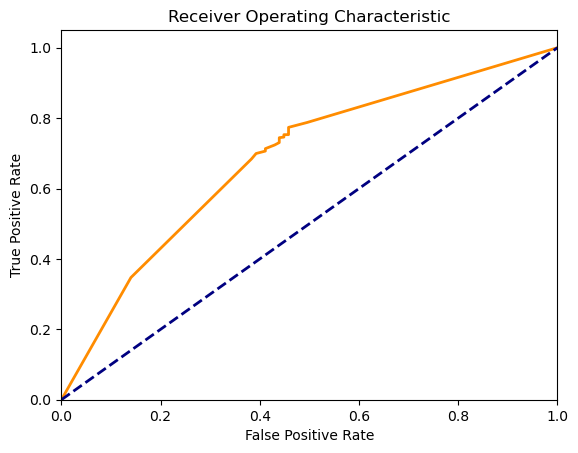

In [95]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate,
         color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.legend(loc="lower right")
plt.show();



In the graph, the dashed line is the baseline representing random guessing, where the true positive rate increases linearly with the false positive rate; its AUC is 0.5. The solid line is the ROC plot of our model, and its AUC is somewhat less than 1. In a perfect case, the true positive samples have a probability of 1, so that the ROC starts at the point with 100% true positive and 0% false positive. The AUC of such a perfect curve is 1. To compute the exact AUC of our model, we can resort to the roc_auc_score function of scikit-learn:



In [96]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test,pos_prob)

0.6857375752586637

What AUC value leads to the conclusion that a classifier is good? Unfortunately, there is no such “magic” number. We use the following rule of thumb as general guidelines: classification models achieving an AUC of 0.7 to 0.8 are considered acceptable, 0.8 to 0.9 are great, and anything above 0.9 are superb. Again, in our case, we are only using the very sparse movie rating data. Hence, an AUC of 0.69 is actually acceptable.



In [97]:
from sklearn.model_selection import StratifiedKFold
k =5 
k_fold = StratifiedKFold(n_splits=k,random_state=None)

After initializing a 5-fold generator, we choose to explore the following values for the following parameters:

**alpha:** This represents the smoothing factor, the initial value for each feature


**fit_prior:** This represents whether to use prior tailored to the training data

We start with the following options:

In [98]:
smoothing_factor_option = [1,2,3,4,5,6]
fit_prior_option = [True,False]
auc_record = {}

Then, for each fold generated by the split() method of the k_fold object, we repeat the process of classifier initialization, training, and prediction with one of the aforementioned combinations of parameters, and record the resulting AUCs:



In [99]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train_k, X_test_k = X[train_indices], X[test_indices]
    Y_train_k, Y_test_k = Y[train_indices], Y[test_indices]
    
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train_k, Y_train_k)
            prediction_prob = clf.predict_proba(X_test_k)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test_k, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)


Finally, we present the results as follows:


In [104]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f' {smoothing} {fit_prior} {auc/k:.5f}')

 1 True 0.65647
 1 False 0.65708
 2 True 0.65795
 2 False 0.65823
 3 True 0.65740
 3 False 0.65801
 4 True 0.65808
 4 False 0.65795
 5 True 0.65814
 5 False 0.65694
 6 True 0.65663
 6 False 0.65719


The (2, False) set enables the best averaged AUC, at 0.65823.
Finally, we retrain the model with the best set of hyperparameters (2, False) and compute the AUC:

In [105]:
clf = MultinomialNB(alpha=2.0,fit_prior=False)
clf.fit(X_train,Y_train)
pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:',roc_auc_score(Y_test,pos_prob))

AUC with the best model: 0.6862056720417091


An AUC of 0.686 is achieved with the fine-tuned model. In general, tweaking model hyperparameters using cross-validation is one of the most effective ways to boost learning performance and reduce overfitting.

